# Learning factors for stock market returns prediction

This document includes the code and several graphical representations related to the study. It is intended to complement the accompanying PDF, which provides a detailed explanation of the methods and presents the results of the analysis. Together, these materials offer a comprehensive view of the approach, combining theoretical insights with practical implementation and interpretation.

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import copy
from sklearn.model_selection import KFold

### Data and history

In [21]:
path = '/Users/maillet/Desktop/QRT/'

X_train = pd.read_csv(path+'X_train.csv', index_col=0, sep=',')
X_train.columns.name = 'date'

Y_train = pd.read_csv(path+'Y_train.csv', index_col=0, sep=',')
Y_train.columns.name = 'date'

In [22]:
np.random.seed(42)

total_stocks = 50
test_size = 5

test_stocks = np.random.choice(X_train.index[:total_stocks], size=test_size, replace=False)

test_data = X_train.loc[test_stocks]
train_data = X_train.drop(index=test_stocks)

test_Y = Y_train.loc[test_stocks]
train_Y = Y_train.drop(index=test_stocks)

X_np_train = train_data.to_numpy().T
X_np_train = np.stack([np.flip(X_np_train[i:i+250], axis=0).T for i in range(len(X_np_train)-250)])
X_torch_train = torch.tensor(X_np_train)

X_np_test = test_data.to_numpy().T
X_np_test = np.stack([np.flip(X_np_test[i:i+250], axis=0).T for i in range(len(X_np_test)-250)])
X_torch_test = torch.tensor(X_np_test)

Y_np_train = train_Y.to_numpy().T
Y_torch_train = torch.tensor(Y_np_train)

Y_np_test = test_Y.to_numpy().T
Y_torch_test = torch.tensor(Y_np_test)

In [23]:
best_model_train = {}
best_model_test = {}
metric_history_train = {}
metric_history_test = {}

## The training loop using k-fold and l1 regularization when necessary

In [24]:
def metric_torch(y_pred, y_true):
    """
    Computes the metric between predicted and true values.
    Input: y_pred (Tensor), y_true (Tensor)
    Returns: average_dot_product (float)
    """
    y_pred = y_pred / y_pred.norm(dim=1, keepdim=True)
    y_true = y_true / y_true.norm(dim=1, keepdim=True)
    dot_products = (y_pred * y_true).sum(dim=1)
    average_dot_product = dot_products.mean()
    return average_dot_product

def orthonormal_torch(A):
    """
    Checks if a matrix is orthonormal.
    Input: A (Tensor)
    Returns: is_orthonormal (bool)
    """
    X = A.T @ A
    identity = torch.eye(X.shape[0], dtype = torch.float64)
    is_orthonormal = torch.allclose(X, identity, atol=1e-6)
    return is_orthonormal

In [25]:
# THE TRAINING LOOP WITH K-FOLD - NOT USED HERE

def train_test_split_kfold(X_train, Y_train, train_index, test_index):
    """
    Splits data into training and testing sets for k-fold cross-validation.
    Input: X_train (DataFrame), Y_train (DataFrame), train_index (list), test_index (list)
    Returns: X_torch_train (Tensor), X_torch_test (Tensor), Y_torch_train (Tensor), Y_torch_test (Tensor)
    """
    
    train_data = X_train.iloc[train_index]
    test_data = X_train.iloc[test_index]
    train_Y = Y_train.iloc[train_index]
    test_Y = Y_train.iloc[test_index]

    X_np_train = train_data.to_numpy().T
    X_np_train = np.stack([np.flip(X_np_train[i:i + 250], axis=0).T for i in range(len(X_np_train) - 250)])
    X_torch_train = torch.tensor(X_np_train)

    X_np_test = test_data.to_numpy().T
    X_np_test = np.stack([np.flip(X_np_test[i:i + 250], axis=0).T for i in range(len(X_np_test) - 250)])
    X_torch_test = torch.tensor(X_np_test)

    Y_np_train = train_Y.to_numpy().T
    Y_torch_train = torch.tensor(Y_np_train)

    Y_np_test = test_Y.to_numpy().T
    Y_torch_test = torch.tensor(Y_np_test)

    return X_torch_train, X_torch_test, Y_torch_train, Y_torch_test

kf = KFold(n_splits=5, shuffle=True, random_state=1234)

def training_loop(current_model, model_name, num_epochs, lr, l_penalization, penal_type, kf):
    """
    Performs the training loop for a given model using K-fold cross-validation.
    Returns the best model based on the highest test metric and its mean performance across all folds.
    """
    best_metric_test = -1
    best_model = None
    fold = 1
    fold_metrics_train = []
    fold_metrics_test = []

    for train_index, test_index in kf.split(X_train):
        print(f"Processing Fold {fold} ...")

        X_torch_train, X_torch_test, Y_torch_train, Y_torch_test = train_test_split_kfold(X_train, Y_train, train_index, test_index)
        model = current_model()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        model.train(True)

        metric_history_fold_train = []
        metric_history_fold_test = []
        for epoch in range(num_epochs):
            optimizer.zero_grad()
            outputs_train = model(X_torch_train)

            m = metric_torch(outputs_train, Y_torch_train)

            if model_name == 'lagrange':
                penalization = model.lmbda * model.lagrange()
            else:
                if penal_type == "l1":
                    penalization = l_penalization * sum(torch.sum(torch.abs(param)) for param in model.parameters())
                else:
                    penalization = l_penalization * sum(torch.sum(param ** 2) for param in model.parameters())

            loss = -m + penalization
            loss.backward()
            optimizer.step()

            if model_name == 'projection':
                model.project_to_stiefel()

            m_test = metric_torch(model(X_torch_test), Y_torch_test)
            m = m.item()
            m_test = m_test.item()
            metric_history_fold_train.append(m)
            metric_history_fold_test.append(m_test)

        # Store metrics for the fold
        fold_metrics_train.append(m)
        fold_metrics_test.append(m_test)

        # Update the best model if needed
        if m_test > best_metric_test:
            print('hello')
            best_metric_test = m_test
            best_metric_train = m
            best_model = model
            best_metric_history_train = metric_history_fold_train
            best_metric_history_test = metric_history_fold_test
            best_model.train(False)

        fold += 1

    # Calculate mean metrics across all folds
    mean_metric_train = sum(fold_metrics_train) / len(fold_metrics_train)
    mean_metric_test = sum(fold_metrics_test) / len(fold_metrics_test)

    print('\n')
    print('\n')
    print(f"Best Train Metric: {best_metric_train:2.5f}")
    print(f"Best Test Metric: {best_metric_test:2.5f}")
    print(f"Mean Train Metric (all folds): {mean_metric_train:2.5f}")
    print(f"Mean Test Metric (all folds): {mean_metric_test:2.5f}")
    
    return best_model


In [26]:
# THE TRAINING LOOP WITHOUT K-FOLD: COMPARING THE MODELS ON THE SAME TRAIN AND VALIDATION SET
def training_loop_wo(current_model, model_name, num_epochs, lr, l_penalization, penal_type, X_torch_train, X_torch_test, Y_torch_train, Y_torch_test):
    """
    Performs the training loop for a given model and stores the best model, metrics, and history.
    Input: current_model (callable), model_name (str), num_epochs (int), lr (float), l1_penalization (float), k_fold (int)
    Returns: None
    """
    best_metric_test = -1
    model = current_model()
    model.parameters()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    model.train(True)

    metric_history_train_c = []
    metric_history_test_c = []
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs_train = model(X_torch_train)

        m = metric_torch(outputs_train, Y_torch_train)
            
        if model_name == 'lagrange':
            penalization = model.lmbda * model.lagrange()
        else:
            if penal_type == "l1":
                penalization = l_penalization * sum(torch.sum(torch.abs(param)) for param in model.parameters())
            else:
                penalization = l_penalization * sum(torch.sum(param ** 2) for param in model.parameters())
            
        loss = - m + penalization
        loss.backward()
        optimizer.step()
            
        if model_name == 'projection':
            model.project_to_stiefel()

        m_test = metric_torch(model(X_torch_test), Y_torch_test)
        m = m.item()
        m_test = m_test.item()
        metric_history_train_c.append(m)
        metric_history_test_c.append(m_test)

        if m_test > best_metric_test:
            if model_name != 'lagrange' or (model_name == 'lagrange' and orthonormal_torch(model.A)): 
                best_metric_test = m_test
                best_metric_train = m
                best_model = copy.deepcopy(model)
                best_model.train(False)

        if epoch % 100 == 0 or epoch == num_epochs - 1:
            print(f"[Epoch: {epoch:3d} | Metric: {m: 2.5f} |  Metric test: {m_test: 2.5f}]")


    best_model_train[model_name] = best_metric_train
    best_model_test[model_name] = best_metric_test
    metric_history_train[model_name] = metric_history_train_c
    metric_history_test[model_name] = metric_history_test_c
    
    print('\n')
    print('\n')
    print(f"Best Train Metric: {best_metric_train:2.5f}")
    print(f"Best Test Metric: {best_metric_test:2.5f}")
    return best_model

# Model 1: QR projection

In [27]:
class model_projection(nn.Module):
    """
    Defines a projection model with parameters A and beta.
    Input: D (int), F (int)
    """
    def __init__(self, D: int = 250, F: int = 10):
        super().__init__()
        torch.manual_seed(12)
        self.D = D
        self.F = F
        self.A = nn.Parameter(self.randomA_torch())
        self.beta = nn.Parameter(torch.randn((self.F), dtype=torch.float64))

    def randomA_torch(self):
        """
        Generates a random orthonormal matrix A.
        Returns: Q (Tensor)
        """
        M = torch.randn(self.D, self.F, dtype=torch.float64)
        Q, _ = torch.linalg.qr(M)
        return Q

    def project_to_stiefel(self):
        """
        Projects matrix A to the Stiefel manifold.
        Returns: None
        """
        with torch.no_grad():
            Q, _ = torch.linalg.qr(self.A)
            self.A.copy_(Q)

    def factors(self, x):
        """
        Computes the factors of the input x.
        Input: x (Tensor)
        Returns: factors (Tensor)
        """
        return torch.matmul(x, self.A)

    def forward(self, x):
        """
        Performs the forward pass of the model.
        Input: x (Tensor)
        Returns: output (Tensor)
        """
        return torch.matmul(self.factors(x), self.beta)

In [28]:
mod_proj = training_loop_wo(model_projection, "projection", 2000, 0.001, 1e-4,  "l1", X_torch_train, X_torch_test, Y_torch_train, Y_torch_test)

[Epoch:   0 | Metric:  0.00917 |  Metric test:  0.00844]
[Epoch: 100 | Metric:  0.14704 |  Metric test:  0.07657]
[Epoch: 200 | Metric:  0.14314 |  Metric test:  0.02374]
[Epoch: 300 | Metric:  0.11694 |  Metric test:  0.03750]
[Epoch: 400 | Metric:  0.14085 |  Metric test:  0.05094]
[Epoch: 500 | Metric:  0.14423 |  Metric test:  0.05232]
[Epoch: 600 | Metric:  0.14610 |  Metric test:  0.05693]
[Epoch: 700 | Metric:  0.14720 |  Metric test:  0.06125]
[Epoch: 800 | Metric:  0.13114 |  Metric test:  0.04369]
[Epoch: 900 | Metric:  0.14792 |  Metric test:  0.06952]
[Epoch: 1000 | Metric:  0.14521 |  Metric test:  0.08199]
[Epoch: 1100 | Metric:  0.14456 |  Metric test:  0.08479]
[Epoch: 1200 | Metric:  0.14542 |  Metric test:  0.08135]
[Epoch: 1300 | Metric:  0.14373 |  Metric test:  0.07353]
[Epoch: 1400 | Metric:  0.13853 |  Metric test:  0.08279]
[Epoch: 1500 | Metric:  0.14683 |  Metric test:  0.07886]
[Epoch: 1600 | Metric:  0.14811 |  Metric test:  0.07849]
[Epoch: 1700 | Metric:  

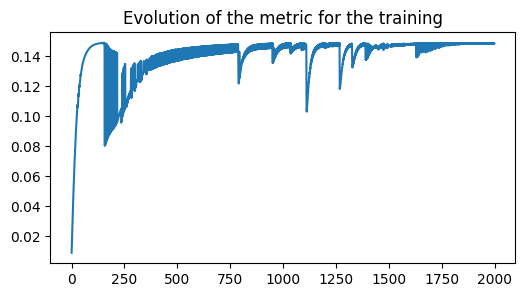

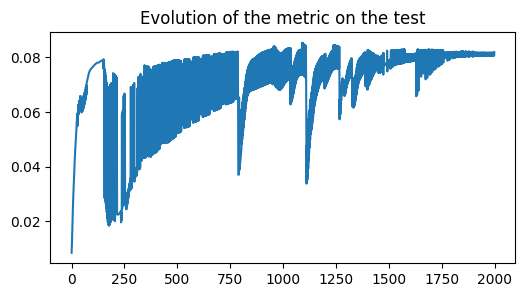

In [29]:
plt.figure(figsize=(6,3))
plt.title("Evolution of the metric for the training")
plt.plot(metric_history_train["projection"])
plt.figure(figsize=(6,3))
plt.title("Evolution of the metric on the test")
plt.plot(metric_history_test["projection"])

The fact that the convergence if not monotonic at all here is very natural because we project the new matrix into the Stiefel manifold after each step.

# Model 2: Lagrange multiplier

In [30]:
class model_lagrange(nn.Module):
    """
    Defines a Lagrange model with parameters A, beta, and lambda.
    Input: D (int), F (int)
    """
    def __init__(self, D: int = 250, F: int = 10):
        super().__init__()
        torch.manual_seed(12)
        self.D = D
        self.F = F
        self.A = nn.Parameter(self.randomA_torch())
        self.beta = nn.Parameter(torch.randn((self.F), dtype=torch.float64))
        self.lmbda = nn.Parameter(torch.randn((1), dtype=torch.float64)[0])

    def randomA_torch(self):
        """
        Generates a random orthonormal matrix A.
        Returns: Q (Tensor)
        """
        M = torch.randn(self.D, self.F, dtype=torch.float64)
        Q, _ = torch.linalg.qr(M)
        return Q

    def lagrange(self):
        """
        Computes the Lagrange penalty term.
        Returns: penalty (Tensor)
        """
        G = torch.matmul(self.A.T, self.A) - torch.eye(self.F)
        G_l = G[torch.triu_indices(self.F, self.F).tolist()]
        return G_l.norm()

    def factors(self, x):
        """
        Computes the factors of the input x.
        Input: x (Tensor)
        Returns: factors (Tensor)
        """
        return torch.matmul(x, self.A)

    def forward(self, x):
        """
        Performs the forward pass of the model.
        Input: x (Tensor)
        Returns: output (Tensor)
        """
        return torch.matmul(self.factors(x), self.beta)


In [31]:
mod_lagrange = training_loop_wo(model_lagrange, "lagrange", 1000, 0.005, 0, "NA", X_torch_train, X_torch_test, Y_torch_train, Y_torch_test)

[Epoch:   0 | Metric:  0.00917 |  Metric test:  0.01092]
[Epoch: 100 | Metric:  0.14893 |  Metric test:  0.08312]
[Epoch: 200 | Metric:  0.14908 |  Metric test:  0.08212]
[Epoch: 300 | Metric:  0.14908 |  Metric test:  0.08203]
[Epoch: 400 | Metric:  0.14908 |  Metric test:  0.08207]
[Epoch: 500 | Metric:  0.14908 |  Metric test:  0.08204]
[Epoch: 600 | Metric:  0.14908 |  Metric test:  0.08205]
[Epoch: 700 | Metric:  0.14908 |  Metric test:  0.08205]
[Epoch: 800 | Metric:  0.14908 |  Metric test:  0.08205]
[Epoch: 900 | Metric:  0.14908 |  Metric test:  0.08205]
[Epoch: 999 | Metric:  0.14908 |  Metric test:  0.08205]




Best Train Metric: 0.14908
Best Test Metric: 0.08205


In [32]:
orthonormal_torch(mod_lagrange.A)

True

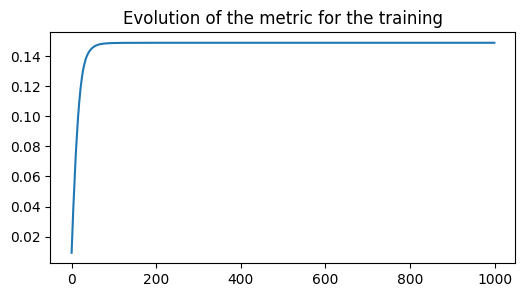

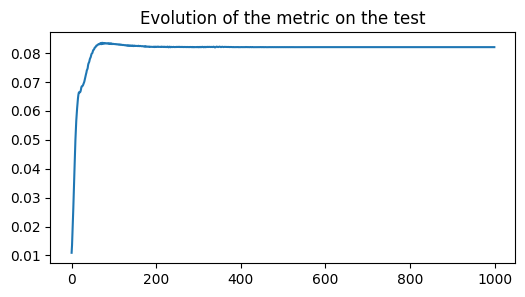

In [33]:
plt.figure(figsize=(6,3))
plt.title("Evolution of the metric for the training")
plt.plot(metric_history_train["lagrange"])
plt.figure(figsize=(6,3))
plt.title("Evolution of the metric on the test")
plt.plot(metric_history_test["lagrange"])

# Model 3: Cayley transform

In [34]:
class model_cayley(nn.Module):
    """
    Defines a Cayley model with parameters X, beta, Delta_tri, and eta.
    Input: D (int), F (int)
    """
    def __init__(self, D: int = 250, F: int = 10):
        super().__init__()
        self.D = D
        self.F = F
        self.X = self.randomA_torch()
        self.beta = nn.Parameter(torch.randn((self.F), dtype=torch.float64))
        self.Delta_tri = nn.Parameter(torch.randn((D*(D-1)//2), dtype=torch.float64))
        self.eta = nn.Parameter(torch.rand(1, dtype=torch.float64))

    def randomA_torch(self):
        """
        Generates a random orthonormal matrix X.
        Returns: Q (Tensor)
        """
        M = torch.randn(self.D, self.F, dtype=torch.float64)
        Q, _ = torch.linalg.qr(M)
        return Q

    def generate_Delta(self):
        """
        Generates a skew-symmetric matrix Delta from Delta_tri.
        Returns: Delta (Tensor)
        """
        O = torch.zeros((self.D, self.D), dtype=torch.float64)
        indices = torch.triu_indices(self.D, self.D, offset=1)
        O[indices[0], indices[1]] = self.Delta_tri
        return O - O.T

    def A(self):
        """
        Computes the Cayley transform of X.
        Returns: A (Tensor)
        """
        I = torch.eye(self.D,  dtype=torch.float64)
        Delta = self.generate_Delta()
        cayley = torch.linalg.inv(I - (self.eta / 2) * Delta) @ (I + (self.eta / 2) * Delta)
        return cayley @ self.X

    def factors(self, x):
        """
        Computes the factors of the input x.
        Input: x (Tensor)
        Returns: factors (Tensor)
        """
        return torch.matmul(x, self.A())

    def forward(self, x):
        """
        Performs the forward pass of the model.
        Input: x (Tensor)
        Returns: output (Tensor)
        """
        return torch.matmul(self.factors(x), self.beta)


In [35]:
mod_cayley = training_loop_wo(model_cayley, "cayley", 2000, 0.01, 1e-4, "l1", X_torch_train, X_torch_test, Y_torch_train, Y_torch_test)

[Epoch:   0 | Metric:  0.01795 |  Metric test:  0.04565]
[Epoch: 100 | Metric:  0.14640 |  Metric test:  0.07886]
[Epoch: 200 | Metric:  0.14807 |  Metric test:  0.08197]
[Epoch: 300 | Metric:  0.14668 |  Metric test:  0.08280]
[Epoch: 400 | Metric:  0.14810 |  Metric test:  0.08747]
[Epoch: 500 | Metric:  0.14762 |  Metric test:  0.08260]
[Epoch: 600 | Metric:  0.14789 |  Metric test:  0.08436]
[Epoch: 700 | Metric:  0.14823 |  Metric test:  0.08670]
[Epoch: 800 | Metric:  0.14779 |  Metric test:  0.08195]
[Epoch: 900 | Metric:  0.14806 |  Metric test:  0.07986]
[Epoch: 1000 | Metric:  0.14816 |  Metric test:  0.08547]
[Epoch: 1100 | Metric:  0.14798 |  Metric test:  0.08293]
[Epoch: 1200 | Metric:  0.14737 |  Metric test:  0.07896]
[Epoch: 1300 | Metric:  0.14796 |  Metric test:  0.08242]
[Epoch: 1400 | Metric:  0.14815 |  Metric test:  0.08196]
[Epoch: 1500 | Metric:  0.14832 |  Metric test:  0.08177]
[Epoch: 1600 | Metric:  0.14779 |  Metric test:  0.08491]
[Epoch: 1700 | Metric:  

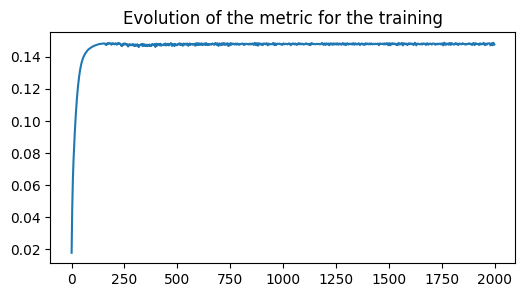

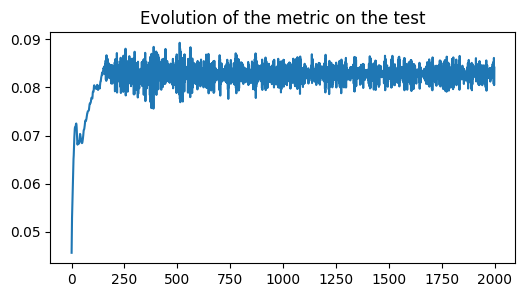

In [36]:
plt.figure(figsize=(6,3))
plt.title("Evolution of the metric for the training")
plt.plot(metric_history_train["cayley"])
plt.figure(figsize=(6,3))
plt.title("Evolution of the metric on the test")
plt.plot(metric_history_test["cayley"])

# Model 4: Exponential Mapping

In [37]:
class model_exp(nn.Module):
    """
    Defines an exponential model with parameters beta, Omega_tri, and K.
    Input: D (int), F (int)
    """
    def __init__(self, D: int = 250, F: int = 10):
        super().__init__()
        self.D = D
        self.F = F
        self.beta = nn.Parameter(torch.randn((self.F), dtype=torch.float64))
        self.Omega_tri = nn.Parameter(torch.randn((self.F*(self.F-1)//2), dtype=torch.float64))
        self.K = nn.Parameter(torch.randn((self.D - self.F, self.F), dtype=torch.float64))

    def randomA_torch(self):
        """
        Generates a random orthonormal matrix.
        Returns: Q (Tensor)
        """
        M = torch.randn(self.D, self.F, dtype=torch.float64)
        Q, _ = torch.linalg.qr(M)
        return Q

    def generate_Omega(self):
        """
        Generates a skew-symmetric matrix Omega from Omega_tri.
        Returns: Omega (Tensor)
        """
        O = torch.zeros((self.F, self.F), dtype=torch.float64)
        indices = torch.triu_indices(self.F, self.F, offset=1)
        O[indices[0], indices[1]] = self.Omega_tri
        return O - O.T

    def generate_Delta(self):
        """
        Generates the Delta matrix from Omega and K.
        Returns: Delta (Tensor)
        """
        Omega = self.generate_Omega()
        O = torch.zeros((self.D - self.F, self.D - self.F), dtype=torch.float64)
        Delta = torch.cat([
            torch.cat([Omega, - self.K.T], dim=1),
            torch.cat([self.K, O], dim=1)
        ], dim=0)
        return Delta

    def A(self):
        """
        Computes the matrix exponential of Delta and returns the first F columns.
        Returns: A (Tensor)
        """
        Delta = self.generate_Delta()
        A = torch.matrix_exp(Delta)[:,:self.F]
        return A

    def factors(self, x):
        """
        Computes the factors of the input x.
        Input: x (Tensor)
        Returns: factors (Tensor)
        """
        return torch.matmul(x, self.A())

    def forward(self, x):
        """
        Performs the forward pass of the model.
        Input: x (Tensor)
        Returns: output (Tensor)
        """
        return torch.matmul(self.factors(x), self.beta)

In [38]:
mod_exp = training_loop_wo(model_exp, "exp", 1000, 0.01, 1e-4, "l1", X_torch_train, X_torch_test, Y_torch_train, Y_torch_test)

[Epoch:   0 | Metric: -0.00042 |  Metric test: -0.00253]
[Epoch: 100 | Metric:  0.14177 |  Metric test:  0.05296]
[Epoch: 200 | Metric:  0.14760 |  Metric test:  0.08432]
[Epoch: 300 | Metric:  0.14826 |  Metric test:  0.08363]
[Epoch: 400 | Metric:  0.14863 |  Metric test:  0.08582]
[Epoch: 500 | Metric:  0.14890 |  Metric test:  0.08466]
[Epoch: 600 | Metric:  0.14902 |  Metric test:  0.08306]
[Epoch: 700 | Metric:  0.14904 |  Metric test:  0.08269]
[Epoch: 800 | Metric:  0.14904 |  Metric test:  0.08242]
[Epoch: 900 | Metric:  0.14906 |  Metric test:  0.08324]
[Epoch: 999 | Metric:  0.14906 |  Metric test:  0.08312]




Best Train Metric: 0.14855
Best Test Metric: 0.08644


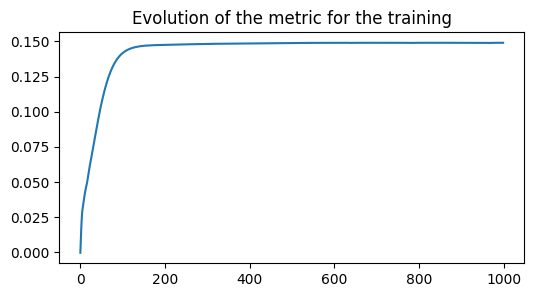

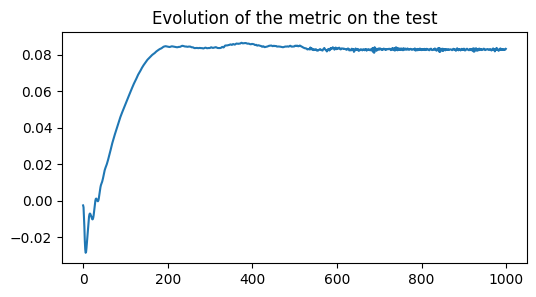

In [39]:
plt.figure(figsize=(6,3))
plt.title("Evolution of the metric for the training")
plt.plot(metric_history_train["exp"])
plt.figure(figsize=(6,3))
plt.title("Evolution of the metric on the test")
plt.plot(metric_history_test["exp"])

# Model 5: Regression approach

In [40]:
class model_regression(nn.Module):
    """
    Defines a regression model with parameter gamma.
    Input: D (int), F (int)
    """
    def __init__(self, D: int = 250, F: int = 10):
        super().__init__()
        self.D = D
        self.F = F
        self.gamma = nn.Parameter(torch.randn((self.D), dtype=torch.float64))

    def randomA_torch(self):
        """
        Generates a random orthonormal matrix A.
        Returns: Q (Tensor)
        """
        M = torch.randn(self.D, self.F, dtype=torch.float64)
        Q, _ = torch.linalg.qr(M)
        return Q

    def generate_A_beta(self):
        A = self.randomA_torch()
        beta = A.T @ self.gamma
        return A, beta

    def forward(self, x):
        """
        Performs the forward pass of the model.
        Input: x (Tensor)
        Returns: output (Tensor)
        """
        return torch.matmul(x, self.gamma)

In [41]:
mod_reg = training_loop_wo(model_regression, 'reg', 3000, 0.001, 1e-4, 'l1', X_torch_train, X_torch_test, Y_torch_train, Y_torch_test)

[Epoch:   0 | Metric:  0.00014 |  Metric test:  0.03634]
[Epoch: 100 | Metric:  0.01226 |  Metric test:  0.04209]
[Epoch: 200 | Metric:  0.02459 |  Metric test:  0.04839]
[Epoch: 300 | Metric:  0.03696 |  Metric test:  0.05333]
[Epoch: 400 | Metric:  0.04913 |  Metric test:  0.05684]
[Epoch: 500 | Metric:  0.06082 |  Metric test:  0.05861]
[Epoch: 600 | Metric:  0.07181 |  Metric test:  0.05830]
[Epoch: 700 | Metric:  0.08198 |  Metric test:  0.05796]
[Epoch: 800 | Metric:  0.09128 |  Metric test:  0.05965]
[Epoch: 900 | Metric:  0.09969 |  Metric test:  0.06259]
[Epoch: 1000 | Metric:  0.10718 |  Metric test:  0.06489]
[Epoch: 1100 | Metric:  0.11373 |  Metric test:  0.06646]
[Epoch: 1200 | Metric:  0.11938 |  Metric test:  0.06761]
[Epoch: 1300 | Metric:  0.12424 |  Metric test:  0.06832]
[Epoch: 1400 | Metric:  0.12841 |  Metric test:  0.06901]
[Epoch: 1500 | Metric:  0.13200 |  Metric test:  0.06969]
[Epoch: 1600 | Metric:  0.13511 |  Metric test:  0.07025]
[Epoch: 1700 | Metric:  

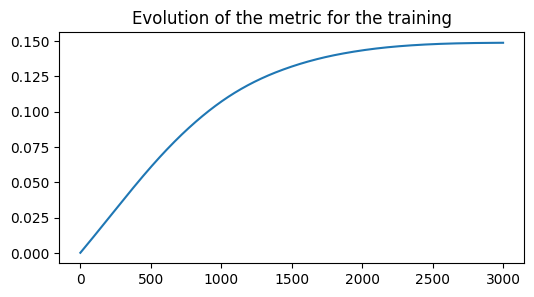

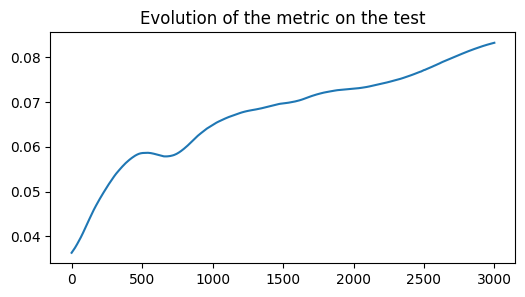

In [42]:
plt.figure(figsize=(6,3))
plt.title("Evolution of the metric for the training")
plt.plot(metric_history_train["reg"])
plt.figure(figsize=(6,3))
plt.title("Evolution of the metric on the test")
plt.plot(metric_history_test["reg"])

# Post-processing and Submission

This depends on the model we use

In [43]:
def parametersTransform_torch(A, beta, D = 250, F = 10):
    if A.shape != (D, F):
        print(f"A must have shape ({D}, {F}), but got {A.shape}")
        return
    
    if not orthonormal_torch(A):
        print('A does not satisfy the constraint')
        return
    
    if beta.shape[0] != F:
        print(f"beta must have shape ({F},), but got {beta.shape}")
        return

    A = A.flatten()
    output = torch.cat([A, beta])
    output_np = output.detach().numpy()
    return output_np

### QR Projection

In [44]:
output = parametersTransform_torch(mod_proj.A, mod_proj.beta)
print(output.shape)
pd.DataFrame(output).to_csv(path + 'Projection.csv')

output_fromCsv = pd.read_csv(path + 'Projection.csv', index_col=0, sep=',').to_numpy()
A = output_fromCsv[:-10].reshape((250, 10))
beta = output_fromCsv[-10:].reshape((10))

(2510,)


### Lagrange

In [45]:
print(mod_lagrange.beta)

Parameter containing:
tensor([-0.8703, -0.7917, -0.3968,  0.0441, -0.1051, -0.3522, -0.7518,  0.2666,
         0.8913, -0.9899], dtype=torch.float64, requires_grad=True)


In [46]:
output = parametersTransform_torch(mod_lagrange.A, mod_lagrange.beta)
print(output.shape)
pd.DataFrame(output).to_csv(path + 'Lagrange.csv')


output_fromCsv = pd.read_csv(path + 'Lagrange.csv', index_col=0, sep=',').to_numpy()
A = output_fromCsv[:-10].reshape((250, 10))
beta = output_fromCsv[-10:].reshape((10))

(2510,)


### Cayley

In [47]:
output = parametersTransform_torch(mod_cayley.A(), mod_cayley.beta)
print(output.shape)
pd.DataFrame(output).to_csv(path + 'Cayley.csv')


output_fromCsv = pd.read_csv(path + 'Cayley.csv', index_col=0, sep=',').to_numpy()
A = output_fromCsv[:-10].reshape((250, 10))
beta = output_fromCsv[-10:].reshape((10))

(2510,)


### Expo map

In [48]:
output = parametersTransform_torch(mod_exp.A(), mod_exp.beta)
print(output.shape)
pd.DataFrame(output).to_csv(path + 'exp.csv')


output_fromCsv = pd.read_csv(path + 'exp.csv', index_col=0, sep=',').to_numpy()
A = output_fromCsv[:-10].reshape((250, 10))
beta = output_fromCsv[-10:].reshape((10))

(2510,)


### Regression

In [49]:
A_reg, beta_reg = mod_reg.generate_A_beta()

output = parametersTransform_torch(A_reg, beta_reg)
print(output.shape)
pd.DataFrame(output).to_csv(path + 'reg.csv')


output_fromCsv = pd.read_csv(path + 'reg.csv', index_col=0, sep=',').to_numpy()
A = output_fromCsv[:-10].reshape((250, 10))
beta = output_fromCsv[-10:].reshape((10))

(2510,)
